# Designing a Direct Air Capture System with energy supply from wind turbines, pv and heat pumps

We want to optimize the design and operation of direct air capturing system with a solid sorbent with electricity provided by wind turbines and pv. Heat requirements are supplied by a heat pump. We will compare the capturing costs and energy requirements between two different locations. The model is based on Wiegner et al. (2022). Optimal Design and Operation of Solid Sorbent Direct Air Capture     Processes at Varying Ambient Conditions. Industrial and Engineering Chemistry Research, 2022, 12649–12667. https://doi.org/10.1021/acs.iecr.2c00681. It resembles operation configuration 1 without water spraying.

## Making the required templates

In [ ]:
from pathlib import Path
import pyhub as ph

root_path = Path("./docs/source/case_studies/dac/")

path_to_nl = root_path / "nl"
path_to_us = root_path / "us"




## Defining the system topology
Here we add as shown in the Figure above:
- The **time horizon** of the model (1st of Januar to 31st of December)
- Two **carriers** (electricity and natural gas)
- Two **nodes** (onshore and offshore)
- Define the **existing technology** gas fired power plant
- Define possible **new technologies** (Wind Turbine offshore, PV onshore
- The possible electricity **connection** to shore (distance of 80 km)

In [2]:
topology = dm.SystemTopology()

# Time Horizon, energy carriers, nodes
topology.define_time_horizon(year=2009,start_date='01-01 00:00', end_date='12-31 23:00', resolution=1)
topology.define_carriers(['electricity', 'gas'])
topology.define_nodes(['onshore', 'offshore'])

# Existing technologies
topology.define_existing_technologies('onshore', {'PowerPlant_Gas': 2000})

# New technologies
topology.define_new_technologies('offshore', ['WindTurbine_Offshore_11000'])
topology.define_new_technologies('onshore', ['Photovoltaic'])

# Electricity connection to shore
connection = dm.create_empty_network_matrix(topology.nodes)
connection.at['onshore', 'offshore'] = 1
connection.at['offshore', 'onshore'] = 1
distance_matrix = dm.create_empty_network_matrix(topology.nodes)
distance_matrix.at['onshore', 'offshore'] = 80
distance_matrix.at['offshore', 'onshore'] = 80

topology.define_new_network('electricityDC_int', connections=connection, distance=distance_matrix)

## Define the input data
Now, we have to define our input data. Some of this is directly done in the code, as shown below. This is:
- Demand
- Climate data (to calculate PV and Wind turbine output)
- Carbon prices
- Import limits
- Prices for imported carriers

Technology and Network data is read from .json files. These .json files contain data on the performance and costs of these components

In [3]:
carbon_price = 90
gas_price = 60

# Initialize instance of DataHandle
data = dm.DataHandle(topology)

# Electricity demand
electricity_demand = pd.read_excel('./cases/wind_meets_gas/Demand.xlsx')
data.read_demand_data('onshore', 'electricity', list(electricity_demand['demand']))

# Climate data
data.read_climate_data_from_file('onshore', './data/climate_data_onshore.txt')
data.read_climate_data_from_file('offshore', './data/climate_data_offshore.txt')

# Carbon price
data.read_carbon_price_data(np.ones(len(topology.timesteps)) * carbon_price, 'tax')

# Allow for gas import for the gas power plant
gas_import_limit = 5000
data.read_import_limit_data('onshore', 'gas', np.ones(len(topology.timesteps)) * gas_import_limit)

# Specify gas price
data.read_import_price_data('onshore', 'gas', np.ones(len(topology.timesteps)) * gas_price)

# Read technology and network data
data.read_technology_data('./cases/wind_meets_gas/Technology_Data/')
data.read_network_data('./cases/wind_meets_gas/Network_Data/')

## Specify configurations and optimize model
The configurations hold some technical stuff about the solution algorithms (when to abort, what algorithms to use,...). Then we can construct the model (i.e. putting together all the equations), and optimize.

In [4]:
configuration = ModelConfiguration()
energyhub = EnergyHub(data, configuration)
results = energyhub.quick_solve()

____________________________________________________________
Reading in data...
Reading in data completed in 0 s
____________________________________________________________
____________________________________________________________
Constructing Model...
____________________________________________________________
--- Adding Networks... ---
	 - Adding Network electricityDC_int
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformation completed in 9 s
____________________________________________________________
--- Adding Node onshore... ---
	 - Adding Technology Photovoltaic
	 - Adding Technology PowerPlant_Gas
____________________________________________________________
--- Adding Node offshore... ---
	 - Adding Technology WindTurbine_Offshore_11000
Constructing model completed in 29 s
____________________________________________________________
Constructing bal

## Plot results of the energy system design

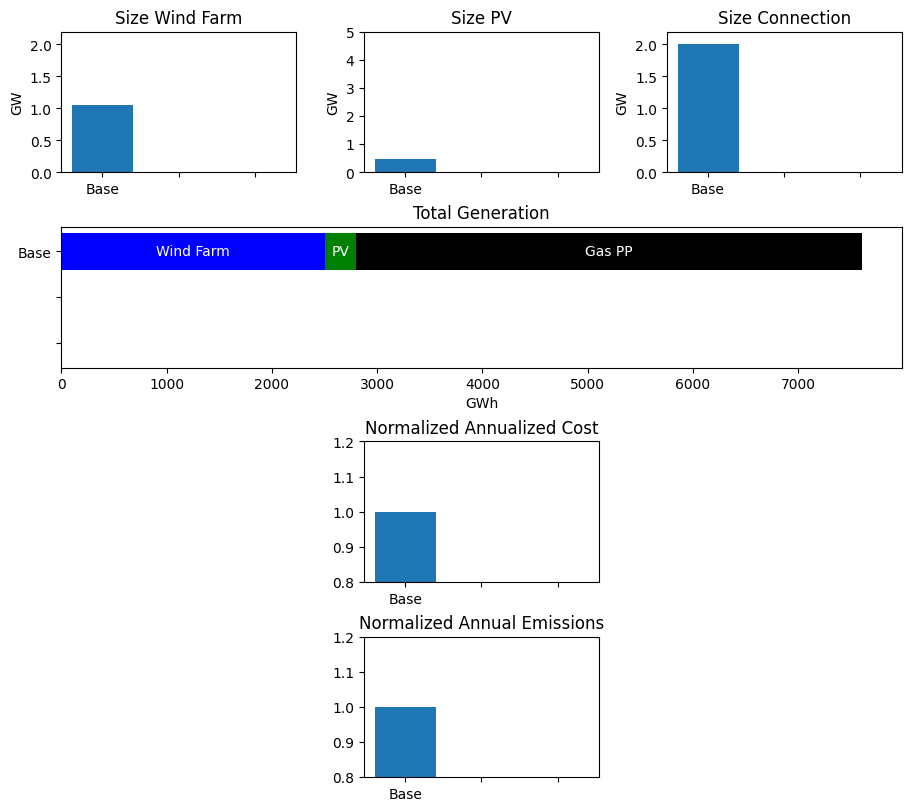

In [5]:
p_res = PlotResults_1(3)
p_res.add_result(results, 'Base')
p_res.plot_result()

## Changing input data
Higher Carbon Tax (x2)

### Optimization

In [6]:
option = 1
carbon_price = 180
data.read_carbon_price_data(np.ones(len(topology.timesteps)) * carbon_price, 'tax')
energyhub = EnergyHub(data, configuration)
results = energyhub.quick_solve()
p_res.add_result(results, 'High CT')
data.read_carbon_price_data(np.ones(len(topology.timesteps)) * 90, 'tax')

____________________________________________________________
Reading in data...
Reading in data completed in 0 s
____________________________________________________________
____________________________________________________________
Constructing Model...
____________________________________________________________
--- Adding Networks... ---
	 - Adding Network electricityDC_int
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformation completed in 8 s
____________________________________________________________
--- Adding Node onshore... ---
	 - Adding Technology Photovoltaic
	 - Adding Technology PowerPlant_Gas
____________________________________________________________
--- Adding Node offshore... ---
	 - Adding Technology WindTurbine_Offshore_11000
Constructing model completed in 26 s
____________________________________________________________
Constructing bal

### Plotting

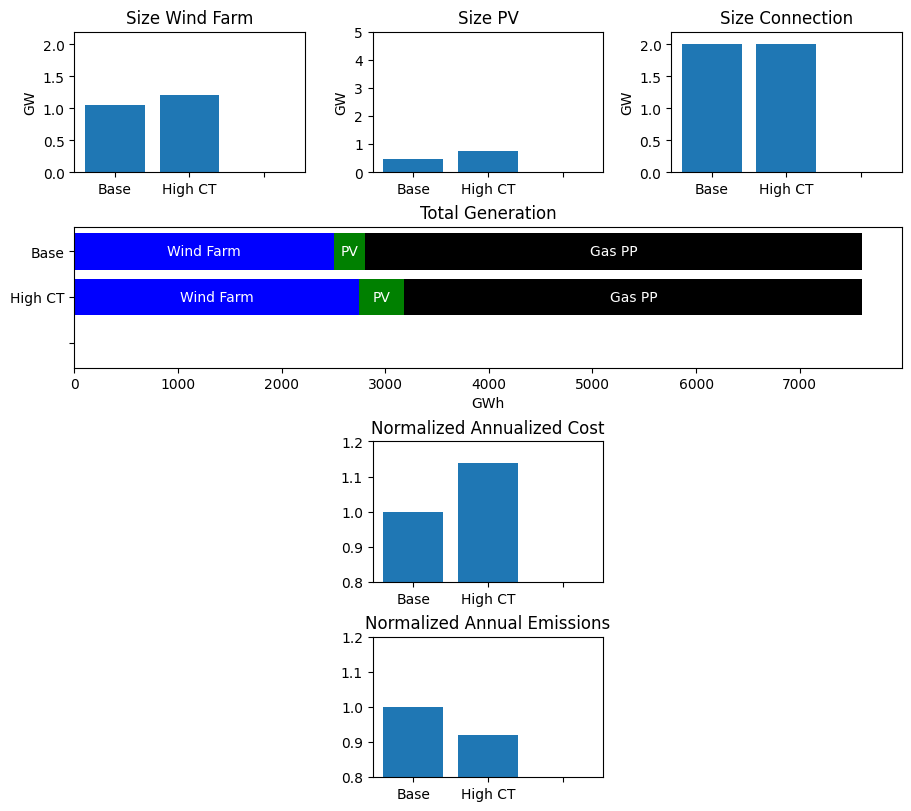

In [7]:
p_res.plot_result()